# Biais froid sur le Plateau Tibétain et projections climatiques (CMIP6)

[PAX7STAF - Variabilité Climatique et Environnementale](https://chamilo.univ-grenoble-alpes.fr/courses/PAX7STAF/index.php?id_session=0)

## Import des modules / packages
- [intake](https://intake-esm.readthedocs.io/en/latest/) : pour accéder aux données 
- [xarray](http://xarray.pydata.org/en/stable/) : pour manipuler les données
- [proplot](https://proplot.readthedocs.io/en/latest/) : pour faire des plots
- [xesmf](https://xesmf.readthedocs.io/en/latest/) : pour faire des regrid (fonctionne seulement pour **Linux** et **Mac**)
- [dask](https://dask.org/) pour faire de la parallélisation (mais vous ne devriez pas tellement vous préocuper de ce packages)

In [1]:
import intake 
import xarray as xr
import proplot as plot
import xesmf as xe # seulement pour Linux et Mac

## Récupération des données CMIP6 via Intake ([tuto](https://intake-esm.readthedocs.io/en/latest/notebooks/tutorial.html))
Cela est possible grâce au projet [Pangeo](https://pangeo.io/) et aux [Google Cloud](https://cloud.google.com/blog/products/data-analytics/new-climate-model-data-now-google-public-datasets) ! (encore assez expérimental)

Autrement il faut télécharger les données sur https://esgf-node.llnl.gov/search/cmip6/ (base de données officielle à l'échelle internationale, mais cela est beaucoup plus fastidieux)

In [2]:
# Visualise toutes les données disponibles (on ne télécharge rien ici pour le moment)

url = "https://raw.githubusercontent.com/NCAR/intake-esm-datastore/master/catalogs/pangeo-cmip6.json"
col = intake.open_esm_datastore(url)
col

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3343: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,unique
activity_id,15
institution_id,34
source_id,79
experiment_id,107
member_id,214
table_id,30
variable_id,392
grid_label,10
zstore,301068
dcpp_init_year,60


In [3]:
col.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,AerChemMIP,AS-RCEC,TaiESM1,histSST,r1i1p1f1,AERmon,od550aer,gn,gs://cmip6/AerChemMIP/AS-RCEC/TaiESM1/histSST/...,NaN,20200310
1,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrbc,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190718
2,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrdust,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127
3,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmroa,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20190809
4,AerChemMIP,BCC,BCC-ESM1,histSST,r1i1p1f1,AERmon,mmrso4,gn,gs://cmip6/AerChemMIP/BCC/BCC-ESM1/histSST/r1i...,NaN,20191127


In [4]:
# Visualise toutes les expériences, modèles et table ici par exemple

import pprint

uni_dict = col.unique(["source_id", "experiment_id", "table_id"])
pprint.pprint(uni_dict, compact=True)

{'experiment_id': {'count': 107,
                   'values': ['1pctCO2', '1pctCO2-bgc', '1pctCO2-rad',
                              'abrupt-0p5xCO2', 'abrupt-2xCO2', 'abrupt-4xCO2',
                              'abrupt-solm4p', 'abrupt-solp4p', 'amip',
                              'amip-4xCO2', 'amip-future4K', 'amip-hist',
                              'amip-lwoff', 'amip-m4K', 'amip-p4K',
                              'amip-p4K-lwoff', 'aqua-4xCO2', 'aqua-control',
                              'aqua-control-lwoff', 'aqua-p4K',
                              'aqua-p4K-lwoff', 'control-1950', 'dcppA-assim',
                              'dcppA-hindcast', 'dcppC-amv-ExTrop-neg',
                              'dcppC-amv-ExTrop-pos', 'dcppC-amv-Trop-neg',
                              'dcppC-amv-Trop-pos', 'dcppC-amv-neg',
                              'dcppC-amv-pos', 'dcppC-atl-control',
                              'dcppC-atl-pacemaker', 'dcppC-hindcast-noAgung',
                 

### Selection des données souhaitées
Ici je mets donc le modèle `IPSL-CM6A-LR` pour la variable `tas` (température de l'air proche de la surface - de manière générale à 2 mètres au-dessus du sol), en mensuel (soit la table Atmosphérique monthly `Amon`). Pour commencer vous pouvez regarder le premier membre `r1i1p1f1` puis ensuite essayer d'estimer la variabilité interne du modèle et estimer une erreur sur vos résultats de projection.

In [5]:
cat = col.search(
    experiment_id=["historical"],
#     experiment_id=["historical", "ssp585"],
    table_id="Amon",
    variable_id="tas",
    source_id="IPSL-CM6A-LR",
    member_id="r1i1p1f1"
)

cat

,unique
activity_id,1
institution_id,1
source_id,1
experiment_id,1
member_id,1
table_id,1
variable_id,1
grid_label,1
zstore,1
dcpp_init_year,0


In [6]:
cat.df.head()

,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
0,CMIP,IPSL,IPSL-CM6A-LR,historical,r1i1p1f1,Amon,tas,gr,gs://cmip6/CMIP/IPSL/IPSL-CM6A-LR/historical/r...,NaN,20180803


In [7]:
cat.keys()

['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']

In [8]:
# Optionnel pour la parallélisation (si vous avez installé dask)

# from dask.distributed import Client
# # client = Client(n_workers=2, threads_per_worker=2, memory_limit='1GB')
# client = Client()
# client

In [9]:
# Cette cellule permet de récupérer les données sous forme de dataset xarray/dask mais rien n'est encore loadé sur votre PC
# Cela peut prendre quelques minutes le temps d'indexer toutes les données

data_source = cat[cat.keys()[0]]
ds = data_source(
    zarr_kwargs={"consolidated": True, "decode_times": True}
).to_dask()

In [11]:
# Visualiser le Dataset

ds

In [12]:
# client.close()

### Vérification de la taille des données

In [12]:
# https://stackoverflow.com/a/14822210/6344670
import math

def convert_size(size_bytes):
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    i = int(math.floor(math.log(size_bytes, 1024)))
    p = math.pow(1024, i)
    s = round(size_bytes / p, 2)
    return "%s %s" % (s, size_name[i])

In [13]:
convert_size(ds.nbytes)

'155.58 MB'

In [21]:
# Juste pour exemple si multimembre, à ne pas faire, si pas en parallèle car peut être très long

# ds.tas.mean('time').compute()

En fonction de la taille il peut être judicieux de sélectionner les données que vous avez besoin avant de faire des opérations afin de ne surcharger la mémoire de votre PC ! (surtout avec tous les membres)

### Chargement des données utiles
Seulement sur la zone HMA par exemple pour réduire grandement la taille des données et également sur le temps

In [14]:
lonlim = slice(50,120)
latlim = slice(0,60)

In [15]:
tas = ds.tas.sel(lon=lonlim, lat=latlim, time=slice('1950','2014'))

In [17]:
# Visualise le DataArray (variable du Dataset)

# tas

In [18]:
convert_size(tas.nbytes)

'4.14 MB'

In [20]:
# Chargement des données (peut-être un peu long mais comme ça les calculs seront ensuite plus rapides !)
# http://xarray.pydata.org/en/stable/dask.html#optimization-tips

tas.load()

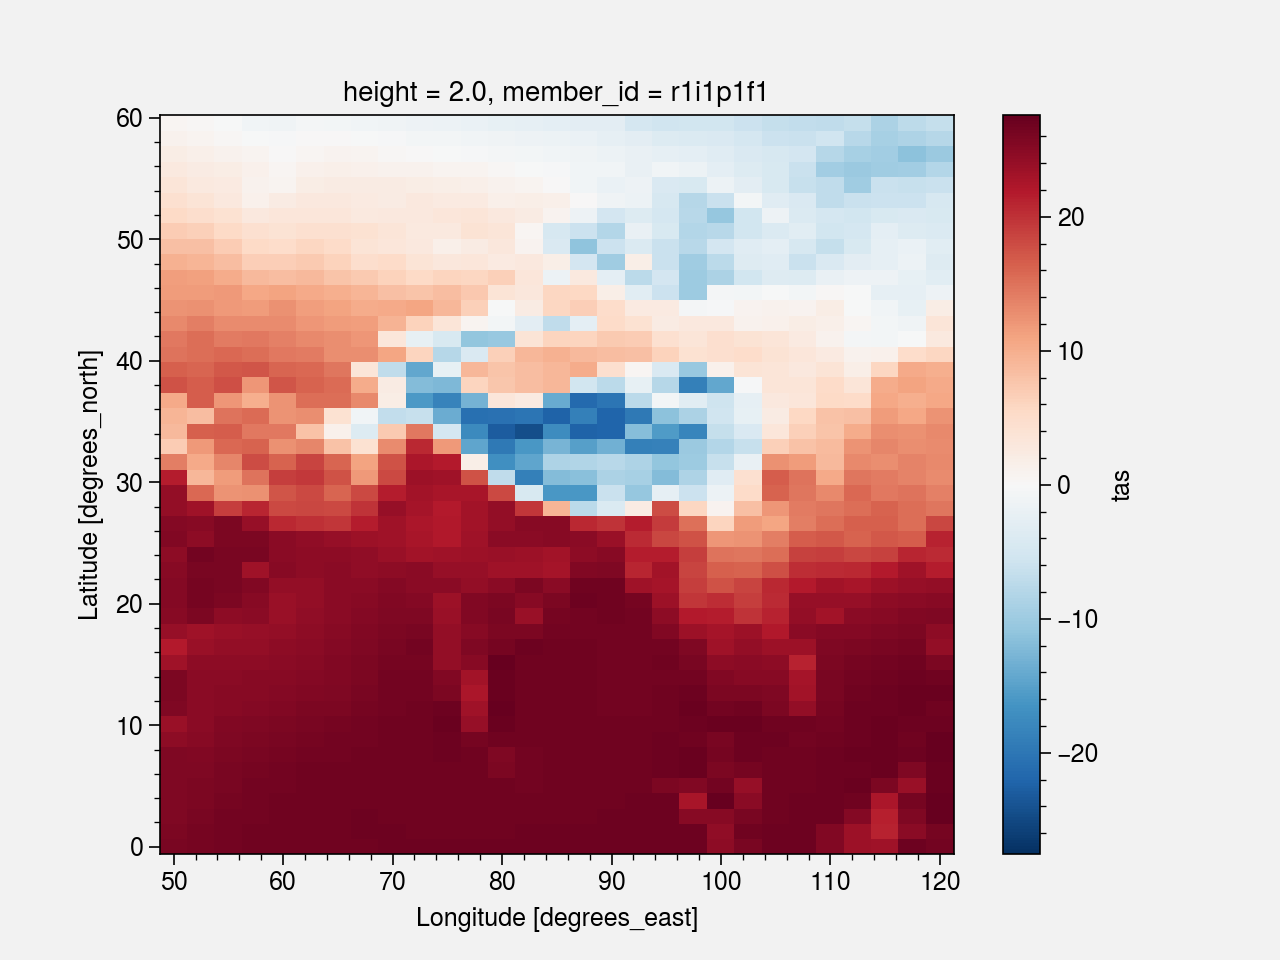

In [21]:
# Visualisation rapide de la climatologie d'un membre
clim = tas.isel(member_id=0).mean('time') - 273.15
clim.plot()

In [22]:
clim.min().values, clim.max().values

(array(-24.40535, dtype=float32), array(27.588898, dtype=float32))

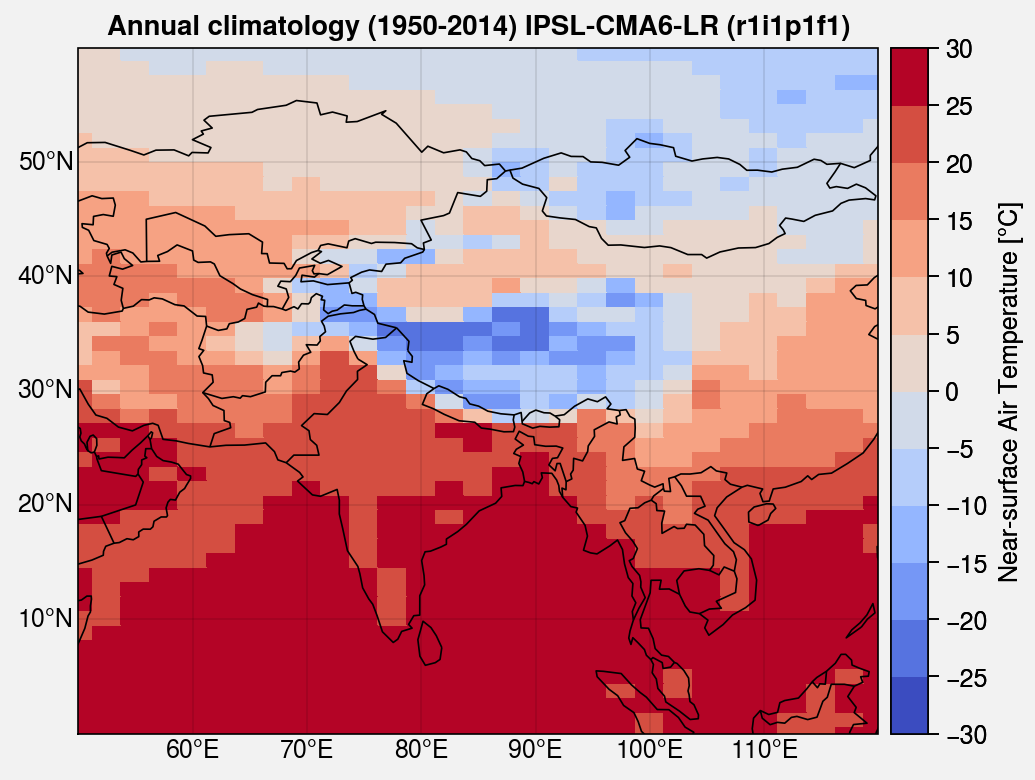

In [23]:
# Visualisation avec Proplot (vous pouvez aussi directement utiliser Cartopy/matplotlib)
# https://proplot.readthedocs.io/en/latest/projections.html

fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-30,30,5)

m = axs[0].pcolormesh(clim, cmap='CoolWarm', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

## Récupération des données d'observation

https://crudata.uea.ac.uk/cru/data/hrg/: CRU TS v. 4.04

Il faut vous créer un compte, ici je vous ai mis un jeu de données de base pour commencer (que j'ai finalement retiré car trop gros mais vous devriez pouvoir le télécharger assez facilement sinon je vous le passerai d'une autre manière), mais vous pouvez ensuite regarder d'autres variables et en particulier le nombre de stations par exemple pour voir dans quelle mesures ces données sont fiables sur cette zone... (faire aussi de la bibliographie, quelle sorte de données c'est : satellite, station, etc. ?)

Si vous voulez ensuite analyser la couverture de neige ou les précipitations, n'hésitez pas à revenir vers moi pour que je vous indique d'autres jeux de données (plus compliqué pour les autres variables mais c'est intéressant si vous voulez comparer !)

In [24]:
# ds_obs = xr.open_dataset('data/cru_ts4.04.1901.2019.tmp.dat.nc')
ds_obs = xr.open_dataset('/home/lalandmi/data/CRU/cru_ts/cru_ts_4.04/data/tmp/cru_ts4.04.1901.2019.tmp.dat.nc')

In [37]:
# ds_obs

In [25]:
clim_obs = ds_obs.tmp.sel(lon=lonlim, lat=latlim, time=slice('1950','2014')).mean('time')

/home/lalandmi/miniconda3/envs/phd_v3/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [26]:
# clim_obs

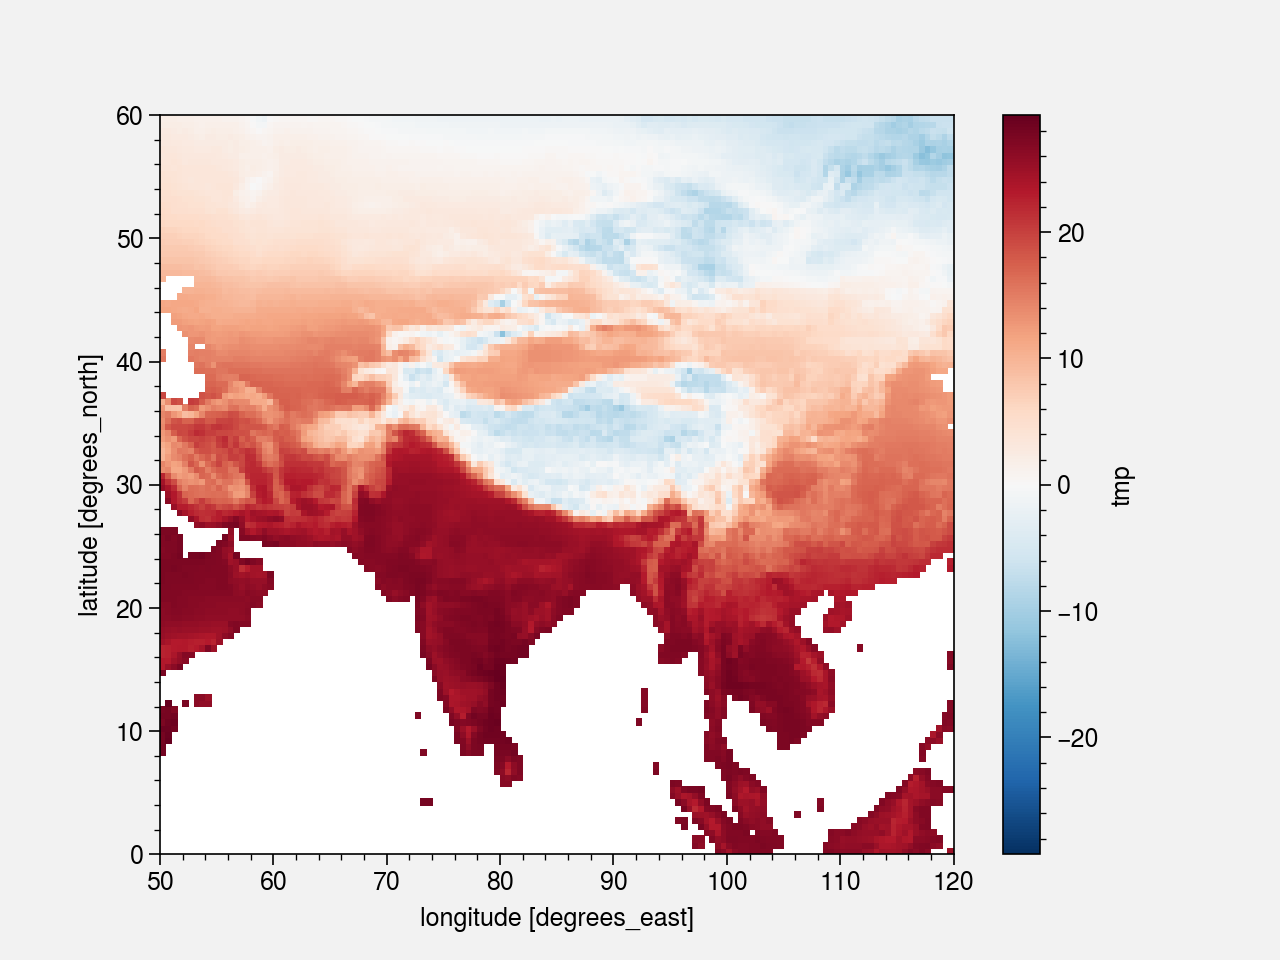

In [27]:
clim_obs.plot()

# Linux et Mac

## Faire un regrid des obs vers le modèle avec [xESMF](https://xesmf.readthedocs.io/en/latest/)
(regrid toujours vers la résolution la moins bonne en général)

Il est également possible de faire directement une interpolation avec xarray (http://xarray.pydata.org/en/stable/interpolation.html), cependant cela ne prend pas en compte la sphéricité de la Terre, du coup c'est mieux xESMF mais si vous n'arrivez pas à le faire fonctionner c'est une alternative (ou également CDO)

In [28]:
# Create the regridder
# Use periodic=True if the data are global
regridder = xe.Regridder(clim_obs, clim, method='bilinear', reuse_weights=True, periodic=False)
clim_obs_regrid = regridder(clim_obs)

Reuse existing file: bilinear_120x140_48x29.nc


# Windows

## Faire un regrid des obs vers le modèle avec `interp` de xarray (http://xarray.pydata.org/en/stable/interpolation.html)
(regrid toujours vers la résolution la moins bonne en général)

Cette méthode d'interpolation ne prend pas en compte la sphéricité de la Terre, mais au final au niveau du Plateau Tibétain cela n'aura pas vraiment d'impact, c'est surtout au niveau des pôles qu'il peut y avoir un différence notable.

In [29]:
clim_obs_interp = clim_obs.interp(lat=clim.lat, lon=clim.lon)

In [33]:
# Interpolation with xarray (ne prend pas en compte la sphéricité de la terre)

clim_obs_interp

In [44]:
# Intepolation with xesmf (prend en compte la sphéricité de la terre)

clim_obs_regrid

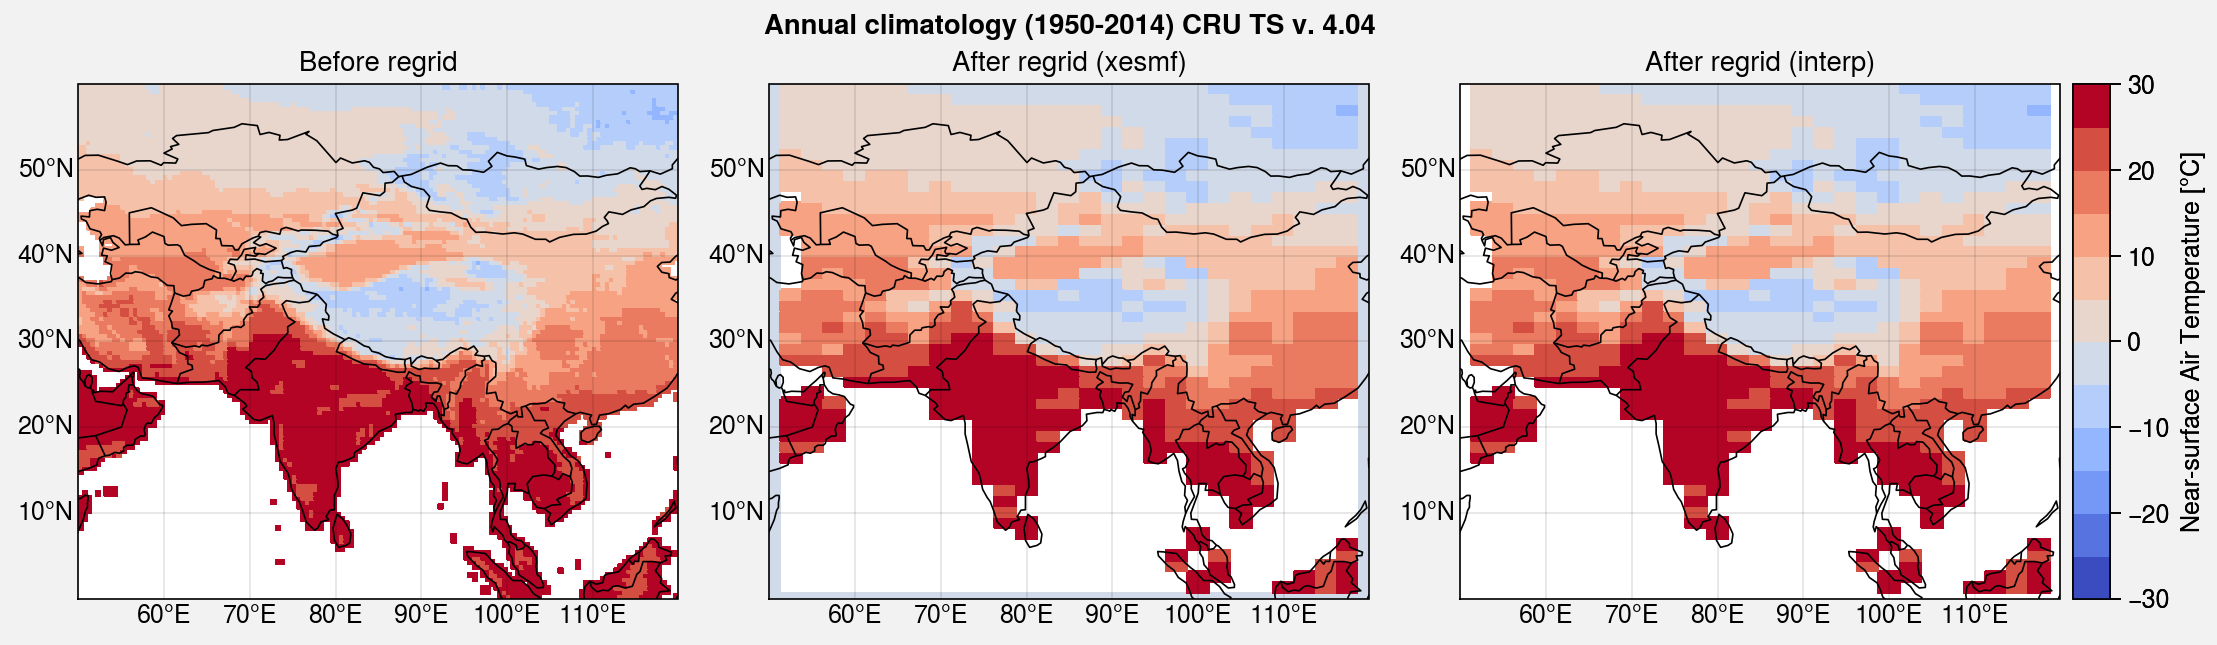

In [36]:
fig, axs = plot.subplots(ncols=3, proj='cyl', axwidth=3)

levels = plot.arange(-30,30,5)
cmap = 'CoolWarm'

m = axs[0].pcolormesh(clim_obs, cmap=cmap, levels=levels)
axs[0].format(title='Before regrid')

axs[1].pcolormesh(clim_obs_regrid, cmap=cmap, levels=levels)
axs[1].format(title='After regrid (xesmf)')

axs[2].pcolormesh(clim_obs_interp, cmap=cmap, levels=levels)
axs[2].format(title='After regrid (interp)')

axs[2].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start, lonlim.stop), latlim=(latlim.start, latlim.stop),
    suptitle='Annual climatology (1950-2014) CRU TS v. 4.04'
)

## Calcul du biais
Le regrid crée quelque effets de bords du coup vous pourrez virer les bords pour les plots suivants. Autrement il faut faire le regrid plus tôt, voir dans l'exemple de la neige où je fais ainsi.

Adapter le nom de la variable en fonction du regrid que vous avez fait (`clim_obs_regrid` ou `clim_obs_interp`)

In [37]:
biais = clim - clim_obs_regrid

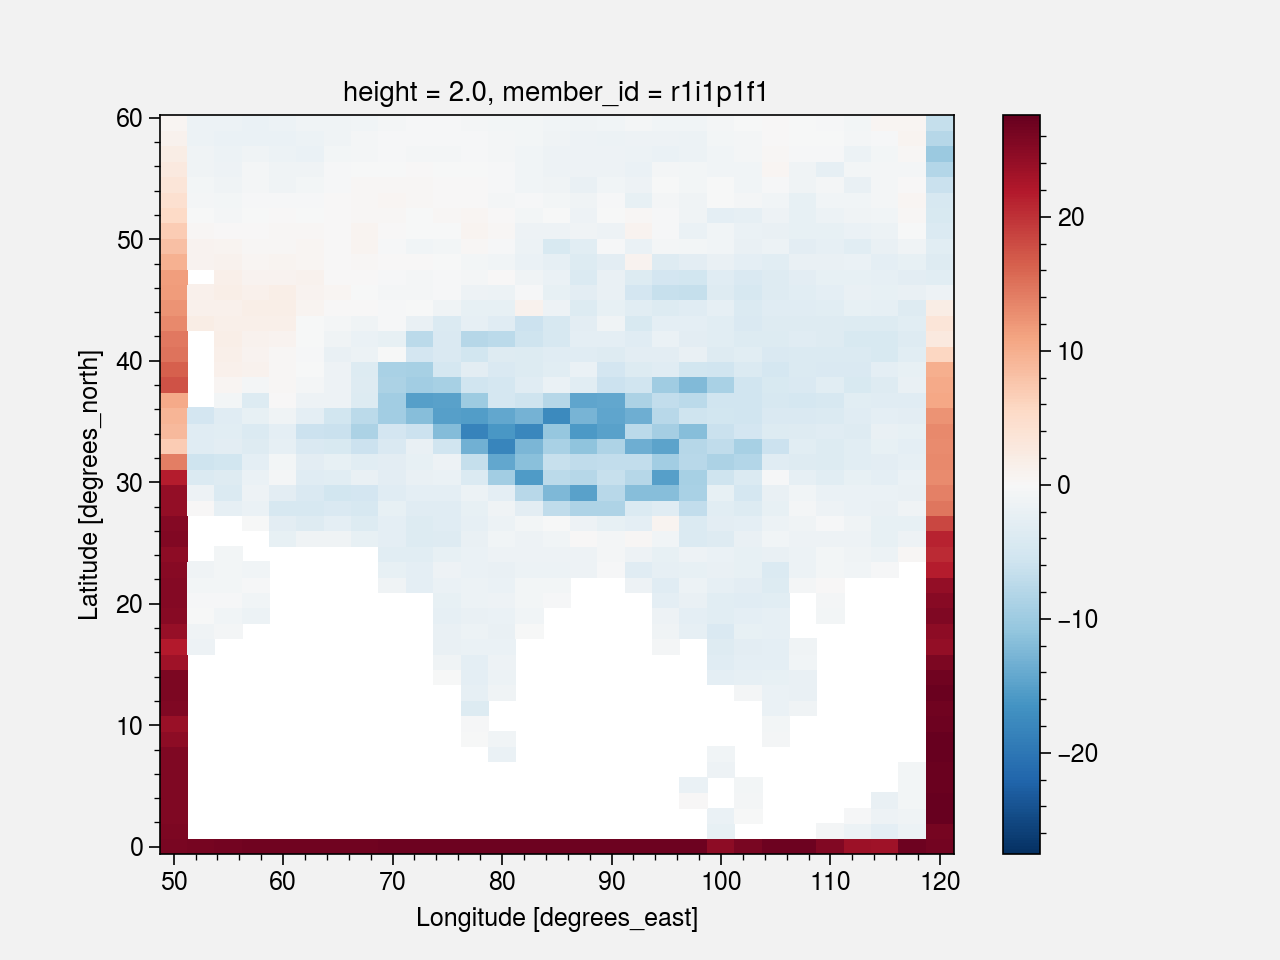

In [38]:
biais.plot()

In [40]:
biais.min().values

array(-18.41134529)

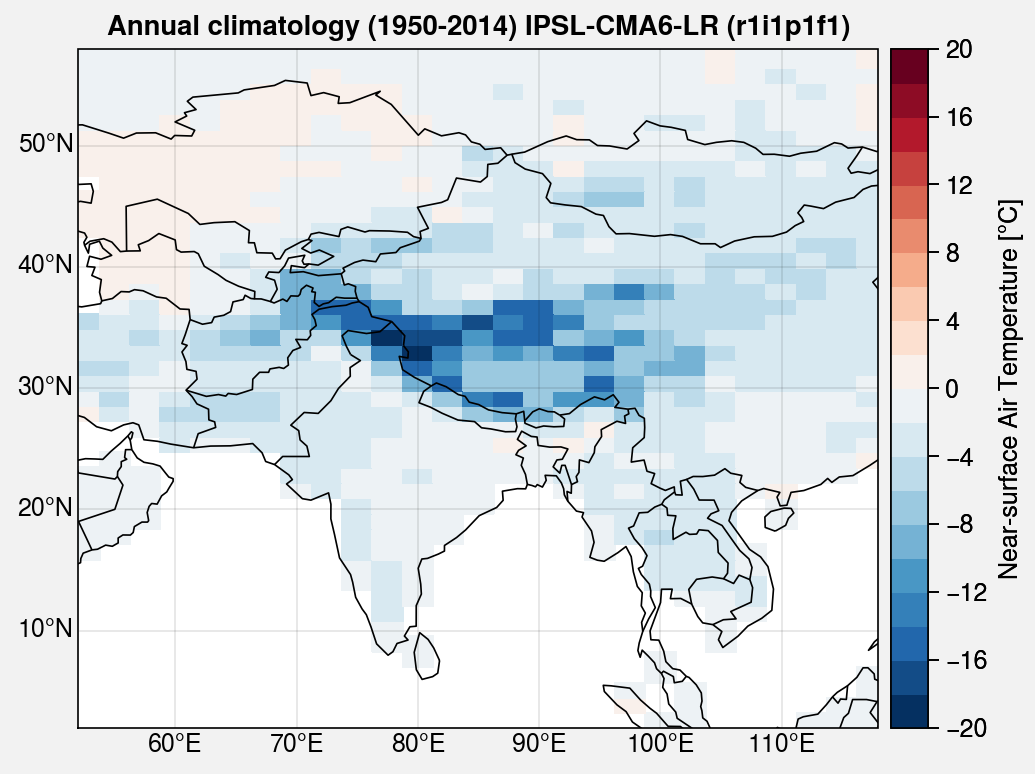

In [41]:
fig, axs = plot.subplots(proj='cyl', axwidth=4)

levels = plot.arange(-20,20,2)

m = axs[0].pcolormesh(biais, cmap='BuRd', levels=levels)
axs[0].colorbar(m, label='Near-surface Air Temperature [°C]')

axs.format(
    borders=True, coast=True, labels=True,
    lonlim=(lonlim.start+2, lonlim.stop-2), latlim=(latlim.start+2, latlim.stop-2), # pour virer les bords +-2, vous pouvez le faire direct sur les données
    suptitle='Annual climatology (1950-2014) IPSL-CMA6-LR ('+str(clim.member_id.values)+')'
)

In [42]:
# Nécessaire seulement si vous avez parallélisé

# client.close()

## Topographie GMTED2010 et suite du travail
Essayez de télécharger le fichier de topographie `GMTED2010_15n240_1000deg.nc` (http://www.temis.nl/data/gmted2010/) et de faire un regrid également vers la grille modèle (ce n'est pas parfait mais bon c'est histoire d'avoir une zone approximative du Plateau Tibétain). Vous pourrez ensuite sélectionner seulement la zone par exemple où l'altitude est supérieure à 2500 m :
```python
clim.where(topo > 2500)
```
Vous pourrez comme ça ensuite calculer un biais moyen sur cette zone (pensez au fait que la Terre est ronde pour faire les moyennes spatiales : http://xarray.pydata.org/en/stable/examples/area_weighted_temperature.html#Creating-weights). L'idée serait ensuite d'utiliser cette zone pour faire des séries temporelles (du coup à appliquer avant de faire la climatologie, vous pouvez faire le regrid plus tôt dans le code). N'hésitez pas à prendre la période que vous voulez (je n'ai fait qu'un exemple ici pour vous familiariser avec le code). Vous pouvez comparer les périodes pré-industrielle à aujourd'hui et/ou aux scénarios futur !

Exemple de plot de projection :

![](img/projection_AR5.png)

Les anomalies sont calculées ici par rapport à la climatologie 1995-2014 pour un membre de chaque modèle. De votre côté pour simplifier vous pouvez vous limiter au seul modèle de l'IPSL mais par contre faire quelque chose de similaire avec tous les 32 membres.

Si vous voulez également faire des calculs de tendances je vous conseille de regarder la fonction `linregress` (https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html). N'hésitez pas à faire toutes sortes d'analyses que vous avez déjà appris (cycle annuel, refaire vos analyses en saisonnier pour voir si le biais est plus important en hiver ou été, etc.)

# A vous de jouer !